In [112]:
!pip install statsbombpy
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 2.7 MB/s eta 0:00:00a 0:00:01


In [113]:
import warnings
from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [38]:
print(sb.competitions())

    competition_id  season_id   country_name        competition_name  \
0                9        281        Germany           1. Bundesliga   
1                9         27        Germany           1. Bundesliga   
2             1267        107         Africa  African Cup of Nations   
3               16          4         Europe        Champions League   
4               16          1         Europe        Champions League   
..             ...        ...            ...                     ...   
69              55         43         Europe               UEFA Euro   
70              35         75         Europe      UEFA Europa League   
71              53        106         Europe       UEFA Women's Euro   
72              72        107  International       Women's World Cup   
73              72         30  International       Women's World Cup   

   competition_gender  competition_youth  competition_international  \
0                male              False                      Fa

We are going to gather the fullbacks from the best leagues in Europe. We search if there is the 20/21 season in the best 5 leagues {Spain,England,Italy,France,Germany}. In this repository we only have data of this season in Spain.

In [ ]:
df_competiciones=sb.competitions()
print(df_competiciones[df_competiciones["season_name"]=='2020/2021'])


    competition_id  season_id country_name         competition_name  \
25              37         90      England  FA Women's Super League   
38              11         90        Spain                  La Liga   

   competition_gender  competition_youth  competition_international  \
25             female              False                      False   
38               male              False                      False   

   season_name               match_updated           match_updated_360  \
25   2020/2021  2023-02-25T14:52:09.326729     2021-06-13T16:17:31.694   
38   2020/2021  2024-07-15T15:15:28.367546  2024-07-15T15:17:45.455234   

           match_available_360             match_available  
25                        None  2023-02-25T14:52:09.326729  
38  2024-07-15T15:17:45.455234  2024-07-15T15:15:28.367546  


In [150]:
df_spanish_matches=sb.matches(competition_id=11,season_id=90)

In [67]:
def match_count(list,player):
    for p in list:
        if p['name']==player:
            return p['stats']['Matches_Played']

In [68]:
def add_player_stats(players_list,stat,name_stat,player,mean):
    for play in players_list:
        if play["name"]==player:
            list_stats=play.get("stats")
            if name_stat in list_stats:
                if mean:
                    prev_stat=list_stats[name_stat]
                    matches_played=match_count(player,players_list)
                    new_mean=(prev_stat*(matches_played-1)+stat)/(matches_played)
                    list_stats[name_stat]=new_mean
                else:
                    list_stats[name_stat]+=stat
                
            else:
                play["stats"].append({name_stat:stat})
        

In [69]:
def investigate_stat(players_list,name_stat,df,percen):
     
    unique_players = df['player'].unique()
    # Recorrer los jugadores únicos y contar sus apariciones
    for player in unique_players:
        #We have to calculate the % of the stat in the game
        if percen is not None:
            full_stat = (percen['player'] == player).sum()
            well_stat = (df['player'] == player).sum()
            stat=(well_stat/full_stat)*100
            add_player_stats(players_list,stat,name_stat,player,True)
        else:
            stat = (df['player'] == player).sum()
            add_player_stats(players_list,stat,name_stat,player,False)

In [100]:
def add_matches_played(players_list,event_df):
    found=False

    for player in players_list:
        name=player['name']
        if name in event_df['player'].unique():
            if player['stats']!=[]:
                for stat in player['stats']:
                    if "Matches_Played" in stat:
                        stat['Matches_Played']+=1
            else:
                player['stats'].append({'Matches_Played':1})
                     
                    


In [71]:
def remove_na(df_list):
    new_list=[]
    for df in df_list:
        df=df.dropna(axis=1,how='all')
        new_list.append(df)
    return new_list

In [72]:
def create_playerslist(players_list,team):
    players_names=[list(p.values())[0] for p in players_list]
    for index, row in team.iterrows():
        player_name = row['player_name']
        positions = row['positions']
        for position in positions:
            if (position['position']=='Left Back' or position['position']=='Right Back') and player_name not in players_names:
                players_list.append({'name':player_name,'stats':[]})
    return players_list

In [73]:
def printearcolumnas(df):
    print(df.columns)

In [151]:
#Vamos a hacer una lista de los mejores laterales de la liga y sus estadísticas a lo largo de la temporada. Por cada jugador vamos a guardar: {'player','stats':[stats we want]}

fullbacks_list=[]

for i,match in enumerate(df_spanish_matches["match_id"]):
    match_events=sb.events(match_id=match)
    teams=match_events['team'].unique()
    print(f"Match {i} : {teams[0]} - {teams[1]}")

    not_barcelona_events=match_events[match_events['team']!='Barcelona']
    lineup=sb.lineups(match_id=match)
    for team in lineup:
        if team!='Barcelona':
                create_playerslist(fullbacks_list,lineup[team])
            
                

    add_matches_played(fullbacks_list,not_barcelona_events)
    #Ball recoveries
    ball_recovery=not_barcelona_events[not_barcelona_events['type']=='Ball Recovery']
    investigate_stat(fullbacks_list,"Ball_Recoveries",ball_recovery[['player']],None)
    #Duels
    duels=not_barcelona_events[not_barcelona_events['type']=='Duel']
    won_duels=not_barcelona_events[not_barcelona_events['duel_outcome']=="Won"]
    investigate_stat(fullbacks_list,"Duels",won_duels[['player']],duels[['player']])
    #Pass completion %
    passes=not_barcelona_events[not_barcelona_events['type']=='Pass']
    
    every_pass=passes[['player','pass_recipient']]
    passes_completed=every_pass.dropna(subset=['pass_recipient'])
    investigate_stat(fullbacks_list,"Passes_Completed",passes_completed[['player']],every_pass[['player']])

    num_dribbles=not_barcelona_events[not_barcelona_events['type']=='Dribble']
    dribbles_completed=num_dribbles[num_dribbles['dribble_outcome']=='Complete']

    investigate_stat(fullbacks_list,"Num_Dribbles",num_dribbles[['player']],None)
    investigate_stat(fullbacks_list,"Dribbles_Completed",dribbles_completed[['player']],num_dribbles[['player']])
    
    interception=not_barcelona_events[not_barcelona_events['type']=='Interception']
    won_interceptions=interception[(interception['interception_outcome']=='Won') | (interception['interception_outcome']=='Success In Play')]
    investigate_stat(fullbacks_list,"Interceptions",won_interceptions[['player']],None)
    print(fullbacks_list)
    print("\n")

    
print(fullbacks_list)



Match 0 : Deportivo Alavés - Barcelona
[{'name': 'Rubén Duarte Sánchez', 'stats': [{'Matches_Played': 1}, {'Ball_Recoveries': 1}, {'Duels': 33.33333333333333}, {'Passes_Completed': 80.0}, {'Interceptions': 2}]}, {'name': 'Martín Aguirregabiria Padilla', 'stats': [{'Matches_Played': 1}, {'Passes_Completed': 100.0}, {'Interceptions': 1}]}, {'name': 'Joaquín Navarro Jiménez', 'stats': [{'Matches_Played': 1}, {'Ball_Recoveries': 1}, {'Duels': 16.666666666666664}, {'Passes_Completed': 86.36363636363636}]}]


Match 1 : Granada - Barcelona
[{'name': 'Rubén Duarte Sánchez', 'stats': [{'Matches_Played': 1}, {'Ball_Recoveries': 1}, {'Duels': 33.33333333333333}, {'Passes_Completed': 80.0}, {'Interceptions': 2}]}, {'name': 'Martín Aguirregabiria Padilla', 'stats': [{'Matches_Played': 1}, {'Passes_Completed': 100.0}, {'Interceptions': 1}]}, {'name': 'Joaquín Navarro Jiménez', 'stats': [{'Matches_Played': 1}, {'Ball_Recoveries': 1}, {'Duels': 16.666666666666664}, {'Passes_Completed': 86.363636363636

#We are going to convert the list we have created into a dataframe for a better analysis. We prepare the df for the analysis based in Barcelona's desires in a Fullback.

In [106]:
players_transformed=[]
for player in fullbacks_list:
    new_dict={"name":player['name']}
    for stat in player['stats']:
        new_dict.update(stat)
    players_transformed.append(new_dict)
df=pd.DataFrame(players_transformed)
print(df)
df = df.drop(df[df['Num_Dribbles']/df['Matches_Played']<2].index)
players_df=df.sort_values(
    by=["Duels","Passes_Completed", "Dribbles_Completed", "Ball_Recoveries", "Interceptions"], 
    ascending=[False, False, False, False, False]
)    



                                       name  Matches_Played  Ball_Recoveries  \
0                      Rubén Duarte Sánchez               2              7.0   
1             Martín Aguirregabiria Padilla               2              2.0   
2                   Joaquín Navarro Jiménez               1              1.0   
3                         Dimitri Foulquier               2              3.0   
4                         Dimitri Foulquier               2              3.0   
5                         Dimitri Foulquier               2              3.0   
6                      Jesús Vallejo Lázaro               1              1.0   
7                      Jesús Vallejo Lázaro               1              1.0   
8               José Antonio Rodríguez Díaz               1              7.0   
9                           Carlos Neva Tey               1              1.0   
10                     Aarón Martín Caricol               1              NaN   
11                   Kevin Vázquez Comes

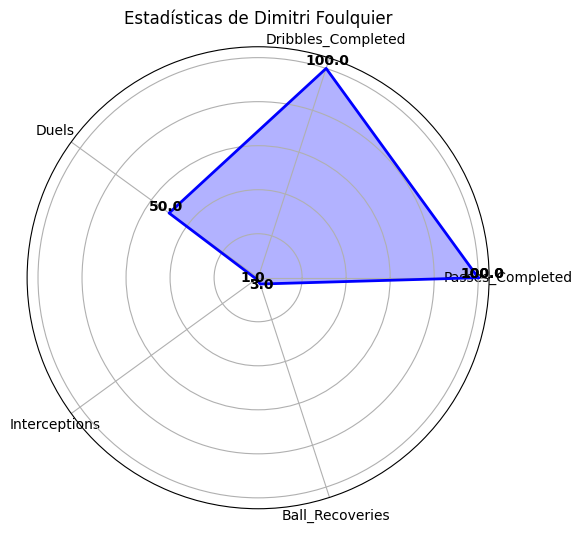

In [117]:


# Seleccionar el primer jugador del ranking para comparar
jugador_top = players_df.iloc[0]
# Variables a comparar
stats = ["Passes_Completed", "Dribbles_Completed", "Duels", "Interceptions", "Ball_Recoveries"]
values = [jugador_top[stat] for stat in stats]

# Convertir a formato circular
values += values[:1]  
angles = np.linspace(0, 2 * np.pi, len(stats), endpoint=False).tolist()
angles += angles[:1]  

# Crear gráfico radar
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color="blue", alpha=0.3)
ax.plot(angles, values, color="blue", linewidth=2)  

for angle, value, label in zip(angles, values, stats + [stats[0]]):
    ax.text(angle, value + 2, str(value), ha='center', fontsize=10, color='black', fontweight='bold')

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(stats)

plt.title(f"Estadísticas de {jugador_top['name']}")
plt.show()